### Consultas y Visualización

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mysql.connector

In [2]:
estadios = mysql.connector.connect(host="localhost", user="root", passwd="julieta2809",database="estadios")

if estadios.is_connected():
    print("Conexión establecida correctamente.")
else:
    print("Problemas con la conexión.")

Conexión establecida correctamente.


In [3]:
cursor = estadios.cursor()

In [4]:
cursor.execute("SELECT confederation, SUM(capacity) FROM estadios_tres_confederaciones GROUP BY confederation ORDER BY SUM(capacity) DESC") 
               
capacidad_por_confedereacion = cursor.fetchall()

for i in capacidad_por_confedereacion:
    print (i)

('UEFA', Decimal('20158727'))
('CONCACAF', Decimal('9001050'))
('CONMEBOL', Decimal('4223002'))


In [5]:
capacidad_df = pd.DataFrame(capacidad_por_confedereacion, columns=[i[0] for i in cursor.description])

capacidad_df



,confederation,SUM(capacity)
0,UEFA,20158727
1,CONCACAF,9001050
2,CONMEBOL,4223002


In [34]:
capacidad_df['SUM(capacity)'] = capacidad_df['SUM(capacity)'].astype(int)
print(capacidad_df['SUM(capacity)'])

0    20158727
1     9001050
2     4223002
Name: SUM(capacity), dtype: int32


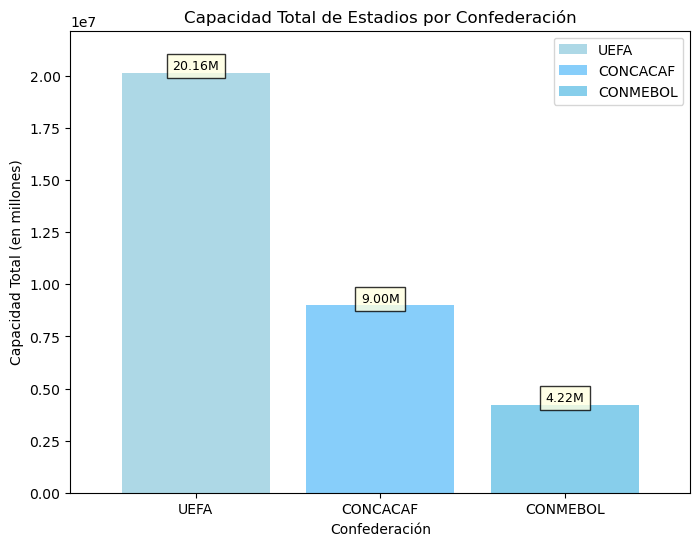

In [103]:
capacidad_df['SUM(capacity)'] = capacidad_df['SUM(capacity)'].astype(int)

plt.figure(figsize=(8, 6))
bars = plt.bar(capacidad_df['confederation'], capacidad_df['SUM(capacity)'], color=['lightblue', 'lightskyblue', 'skyblue'])
plt.xlabel('Confederación')
plt.ylabel('Capacidad Total (en millones)')
plt.title('Capacidad Total de Estadios por Confederación')
plt.margins(0.1)
plt.legend(bars, capacidad_df['confederation'])

for i, valor in enumerate(capacidad_df['SUM(capacity)']):
    plt.text(i, valor, f'{valor/1e6:.2f}M', ha='center', va='bottom', color='black', fontsize=9, 
             bbox = dict(facecolor = 'lightyellow', alpha =.8))

plt.show()

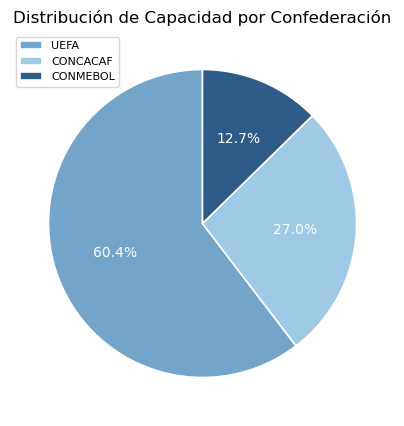

In [132]:
plt.figure(figsize=(5,5))
plt.pie(capacidad_df['SUM(capacity)'],
        startangle = 90, autopct = '%1.1f%%', colors=["#73A4CA", "#9FCAE6", "#2E5B88"], 
        wedgeprops = {"linewidth": 1.2, "edgecolor": "white"},textprops={'color': 'white'})

plt.legend(capacidad_df['confederation'],loc='upper left', fontsize=8)
plt.title('Distribución de Capacidad por Confederación');

In [ ]:
# Esto puede servirme para utilizarla en todo tipo de gráfico.

# def addlabels(x,y):
#     for i in range(len(x)):
#         plt.text(i, y[i], y[i], ha = 'center'
#           Bbox = dict(facecolor = 'red', alpha =.8))

In [153]:
cursor.execute("SELECT country AS País, SUM(capacity) AS Capacidad FROM estadios_tres_confederaciones WHERE confederation = 'conmebol' GROUP BY country ORDER BY SUM(capacity) DESC") 
               
capacidades_conmebol = cursor.fetchall()

for i in capacidad_por_confedereacion:
    print (i)

('Brazil', Decimal('1614462'))
('Argentina', Decimal('746576'))
('Chile', Decimal('401683'))
('Venezuela', Decimal('361597'))
('Colombia', Decimal('286529'))
('Peru', Decimal('216661'))
('Paraguay', Decimal('187000'))
('Ecuador', Decimal('180754'))
('Uruguay', Decimal('137740'))
('Bolivia', Decimal('90000'))


In [154]:
capacidades_conmebol_df = pd.DataFrame(capacidades_conmebol, columns=[i[0] for i in cursor.description])

In [155]:
capacidades_conmebol_df

,País,Capacidad
0,Brazil,1614462
1,Argentina,746576
2,Chile,401683
3,Venezuela,361597
4,Colombia,286529
5,Peru,216661
6,Paraguay,187000
7,Ecuador,180754
8,Uruguay,137740
9,Bolivia,90000


In [ ]:
capacidad_df['SUM(capacity)'] = capacidad_df['SUM(capacity)'].astype(int)

plt.figure(figsize=(8, 6))
bars = plt.bar(capacidad_df['confederation'], capacidad_df['SUM(capacity)'], color=['lightblue', 'lightskyblue', 'skyblue'])
plt.xlabel('Confederación')
plt.ylabel('Capacidad Total (en millones)')
plt.title('Capacidad Total de Estadios por Confederación')
plt.margins(0.1)
plt.legend(bars, capacidad_df['confederation'])

for i, valor in enumerate(capacidad_df['SUM(capacity)']):
    plt.text(i, valor, f'{valor/1e6:.2f}M', ha='center', va='bottom', color='black', fontsize=9, 
             bbox = dict(facecolor = 'lightyellow', alpha =.8))

plt.show()

In [95]:
!git add Consultas_Visualización.ipynb

In [96]:
!git commit -m "Creo dos gráficos, baras y pie."

[main 04e5c8f] Creo dos grÃ¡ficos, baras y pie.
 1 file changed, 77 insertions(+), 129 deletions(-)


In [98]:
!git push

Everything up-to-date
